In [1]:
from skimage.io import imread, MultiImage
from matplotlib.pylab import plt
import numpy as np

In [2]:
def plot_single(im, subplot_kwargs={'figsize':(5,5), 'dpi':150}, imshow_kwargs={}):
    fig, ax = plt.subplots(1,1, **subplot_kwargs)
    ax.imshow(im, **imshow_kwargs)
    ax.axis('off')

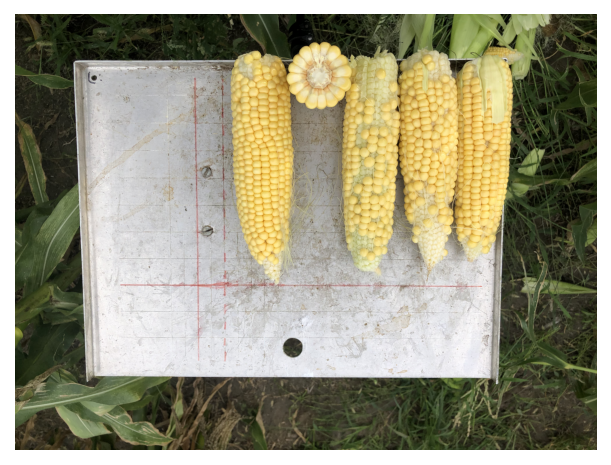

In [3]:
# Load the image
image_path = "../data/images/IMG_8248.jpg"
image = imread(image_path)
plot_single(image)

In [15]:
from pathlib import Path
mask_path_parent = Path("../data/masks/IMG_8248/")

masks = []

for mp in mask_path_parent.iterdir():
    label = str(mp).split('/')[-1].split('.')[0]
    mask = imread(mp)
    masks.append((mask, label))

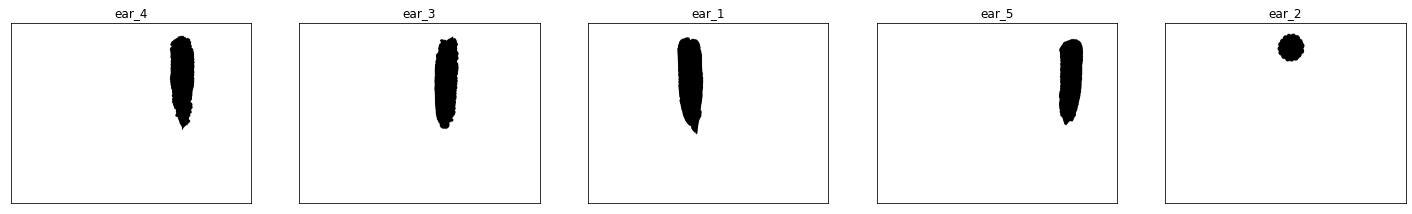

In [8]:
num_masks = len(masks)
fig, axs = plt.subplots(1, num_masks, figsize=(num_masks * 5, 5))
for i, ax in enumerate(axs):
    ax.imshow(masks[i][0], cmap='gray')
    ax.set_title(masks[i][1])
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

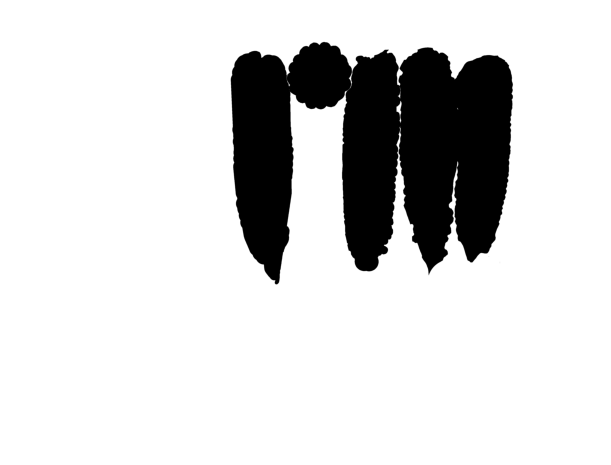

In [55]:
def combine_masks(masks):
    all_masks = masks[0][0]
    for m in masks:
        all_masks = all_masks & m[0]
    return all_masks

all_masks = combine_masks(masks)
plot_single(all_masks, imshow_kwargs={'cmap' : 'gray'})

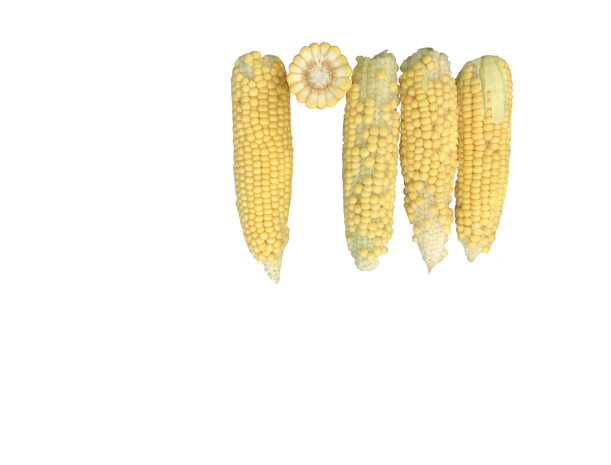

In [31]:
masked_image = image.copy()
masked_image[all_masks != 0] = 255
plot_single(masked_image)

In [34]:
all_masks.shape

(3024, 4032)

In [41]:
masked_ear_values = image[all_masks == 0]

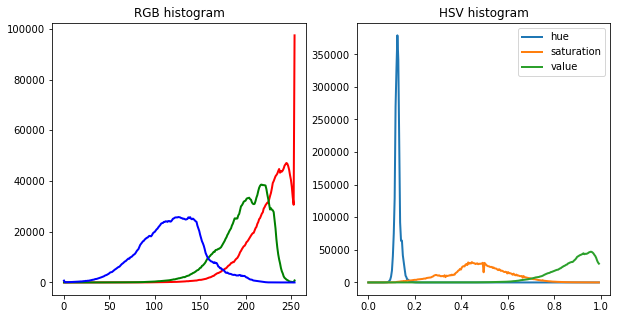

In [53]:
from skimage.color import rgb2hsv

def plot_histograms(image, mask, condition=lambda x: x==0, rgb_bins=np.arange(0, 256), hsv_bins=np.arange(0, 1, 1/256)):
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].set_title('RGB histogram')
    axs[1].set_title('HSV histogram')
    hsv_image = rgb2hsv(image)
    masked_rgb_values = image[condition(mask)]
    masked_hsv_values = hsv_image[condition(mask)]
    colors = ['red', 'green', 'blue']
    for i in range(3):
        hist = np.histogram(masked_rgb_values.T[i], bins=rgb_bins)
        axs[0].plot(hist[1][:-1], hist[0], lw=2, c=colors[i])
    for i in range(3):
        hist = np.histogram(masked_hsv_values.T[i], bins=hsv_bins)
        axs[1].plot(hist[1][:-1], hist[0], lw=2)
        axs[1].legend(['hue', 'saturation', 'value'])
    
    
plot_histograms(image, all_masks)

We can also use this mask to look at everything in the background:

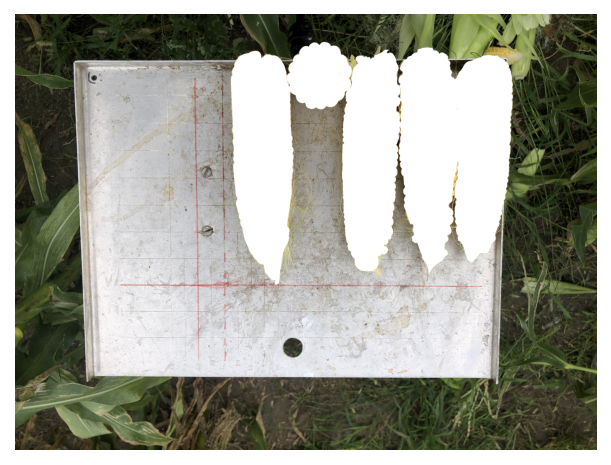

In [69]:
masked_image = image.copy()
masked_image[all_masks == 0] = 255
plot_single(masked_image)

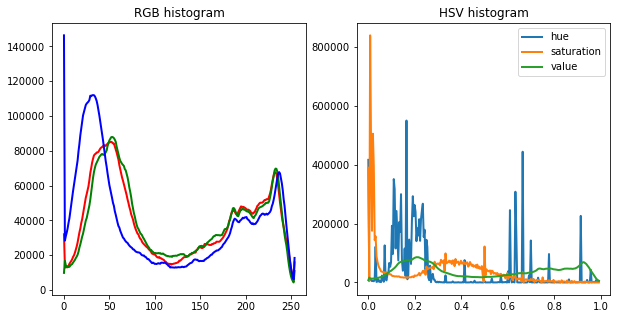

In [59]:
plot_histograms(image, all_masks, condition=lambda x: x!=0)

Some of this code was modified from the thresholding code used [here](https://github.com/colbrydi/Scientific_Image_Understanding/blob/main/02-Segmentation_in-class-assignment.ipynb)


In [80]:
def color_threshold(im, rmin=-1,rmax=256,gmin=-1,gmax=256,bmin=-1,bmax=256, plot=True):
    # Pull out the red, gree and blue matrixes
    r = im[:,:,0]
    g = im[:,:,1]
    b = im[:,:,2]
    b_img = ((r > rmin) & (r < rmax) & 
             (g > gmin) & (g < gmax) & 
             (b > bmin) & (b < bmax))
    if plot:
        plt.figure(figsize = (10,20))
        plt.imshow(b_img, cmap='gray', vmin=0, vmax=1, interpolation='nearest')
        plt.show()
    return b_img*1

In [81]:
from ipywidgets import interactive,fixed

w = interactive(color_threshold, im=fixed(image),
         rmin=(-1,256), rmax=(-1,256), 
         gmin=(-1,256), gmax=(-1,256), 
         bmin=(-1,256), bmax=(-1,256),__manual=True);
w

interactive(children=(IntSlider(value=-1, description='rmin', max=256, min=-1), IntSlider(value=256, descripti…

In [82]:
def hsv_threshold(im, hmin=-0.01,hmax=1.0, smin=-0.01,smax=1.0, vmin=-0.01,vmax=1.0, plot=True):
    h = im[:,:,0]
    s = im[:,:,1]
    v = im[:,:,2]
    b_img = ((h > hmin) & (h <= hmax) &
             (s > smin) & (s <= smax) &
             (v > vmin) & (v <= vmax))
    if plot:
        plt.figure(figsize = (10,20))
        plt.imshow(b_img, cmap='gray', vmin=0, vmax=1, interpolation='nearest') # interpolation=nearest prevents matplotlib from "smoothing" the edges out
        plt.show()
    return b_img*1

In [83]:
hsv_image = rgb2hsv(image)
w = interactive(hsv_threshold, im=fixed(hsv_image),
         hmin=(-0.01,1.0,0.01), hmax=(-0.01,1.0,0.01), 
         smin=(-0.01,1.0,0.01), smax=(-0.01,1.0,0.01), 
         vmin=(-0.01,1.0,0.01), vmax=(-0.01,1.0,0.01),__manual=True);
w

interactive(children=(FloatSlider(value=-0.01, description='hmin', max=1.0, min=-0.01, step=0.01), FloatSlider…

In [114]:
rgb_mask = {
    'rmin' : 160,
    'rmax' : 256,
    'gmin' : 98,
    'gmax' : 256,
    'bmin' : -1,
    'bmax' : 256
}

hsv_mask = {
    'hmin' : 0.10,
    'hmax' : 0.20,
    'smin' : 0.10,
    'smax' : 1.00,
    'vmin' : 0.23,
    'vmax' : 1.00
}
rgb_mask_im = color_threshold(image, **rgb_mask, plot=False)
hsv_mask_im = hsv_threshold(hsv_image, **hsv_mask, plot=False)
both_masks = rgb_mask_im & hsv_mask_im

Text(0.5, 1.0, "Both masks &'d together")

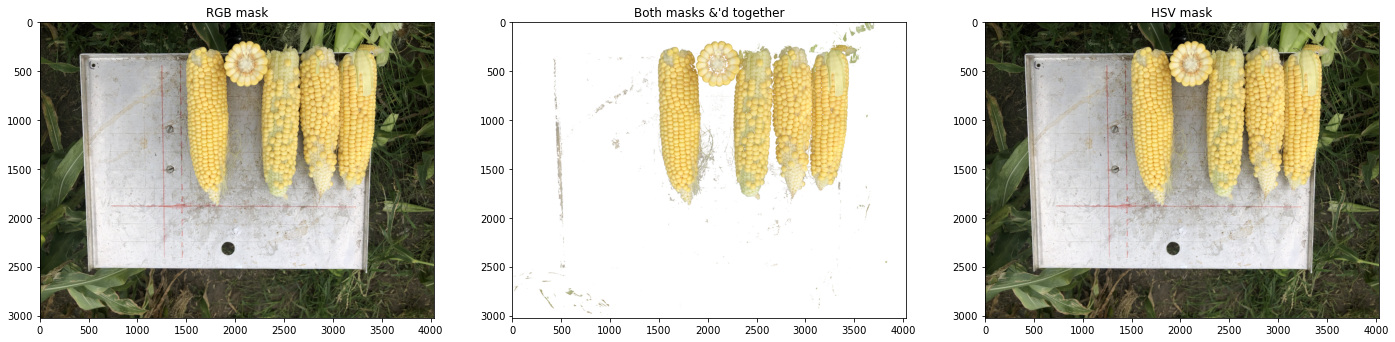

In [115]:
fig, axs = plt.subplots(1,3, figsize=(24,8))

masked_image = image.copy()
masked_image[rgb_mask == 0] = 255
axs[0].imshow(masked_image)
axs[0].set_title("RGB mask")

masked_image = image.copy()
masked_image[hsv_mask == 0] = 255
axs[2].imshow(masked_image)
axs[2].set_title("HSV mask")

masked_image = image.copy()
masked_image[both_masks == 0] = 255
axs[1].imshow(masked_image)
axs[1].set_title("Both masks &'d together")

Let's try a different image

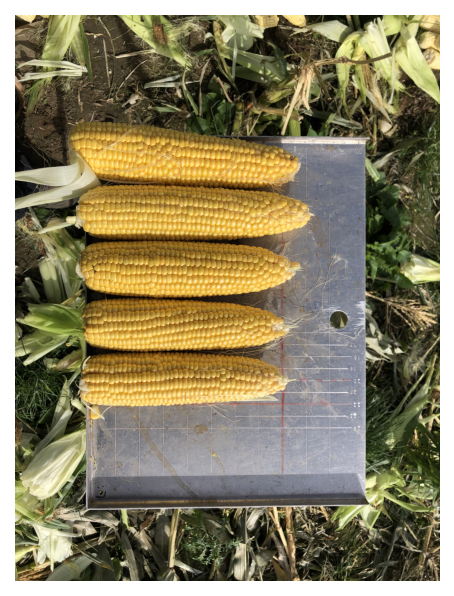

In [116]:
image2_path = "../data/images/IMG_8280.jpg"
image2 = imread(image2_path)
plot_single(image2)

Text(0.5, 1.0, "Both masks &'d together")

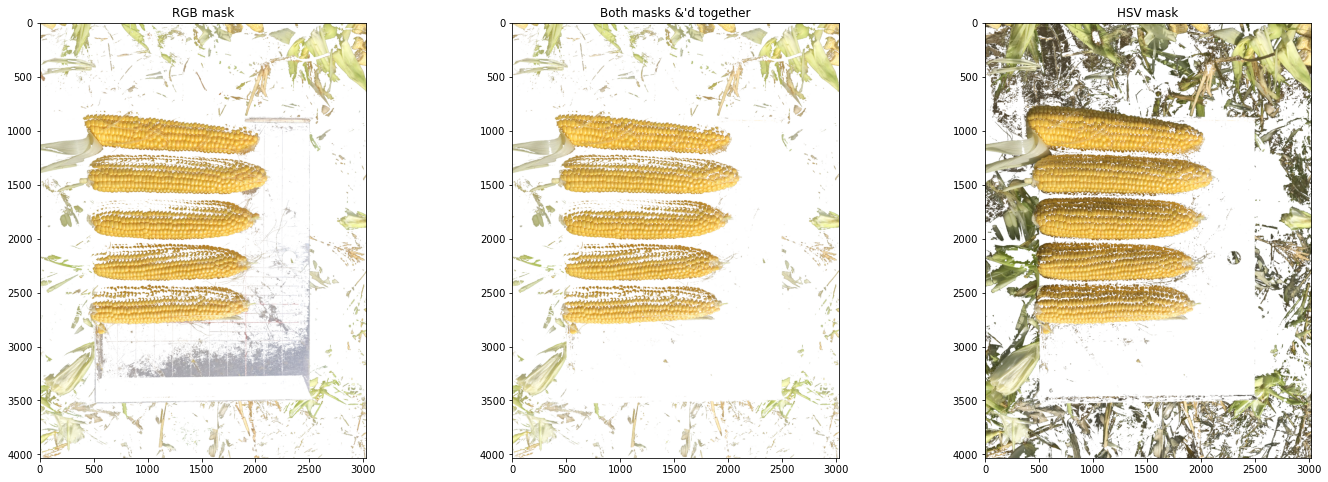

In [118]:
rgb_mask_im = color_threshold(image2, **rgb_mask, plot=False)
hsv_image2 = rgb2hsv(image2)
hsv_mask_im = hsv_threshold(hsv_image2, **hsv_mask, plot=False)
both_masks = rgb_mask_im & hsv_mask_im

fig, axs = plt.subplots(1,3, figsize=(24,8))

masked_image = image2.copy()
masked_image[rgb_mask_im == 0] = 255
axs[0].imshow(masked_image)
axs[0].set_title("RGB mask")

masked_image = image2.copy()
masked_image[hsv_mask_im == 0] = 255
axs[2].imshow(masked_image)
axs[2].set_title("HSV mask")

masked_image = image2.copy()
masked_image[both_masks == 0] = 255
axs[1].imshow(masked_image)
axs[1].set_title("Both masks &'d together")

# Looking at insect damage

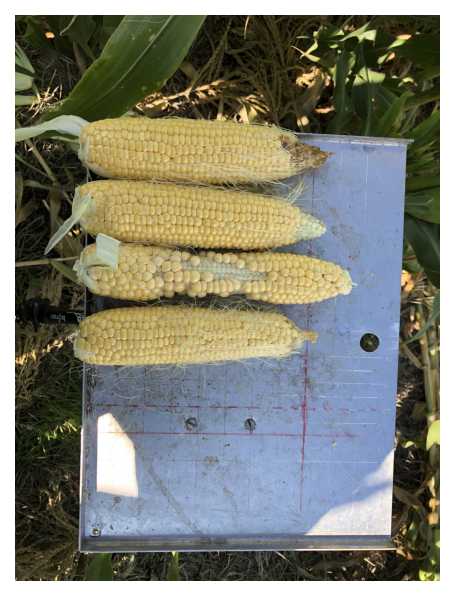

In [120]:
image_with_damage_path = "../data/images/IMG_8302.jpg"
image_with_damage = imread(image_with_damage_path)
plot_single(image_with_damage)

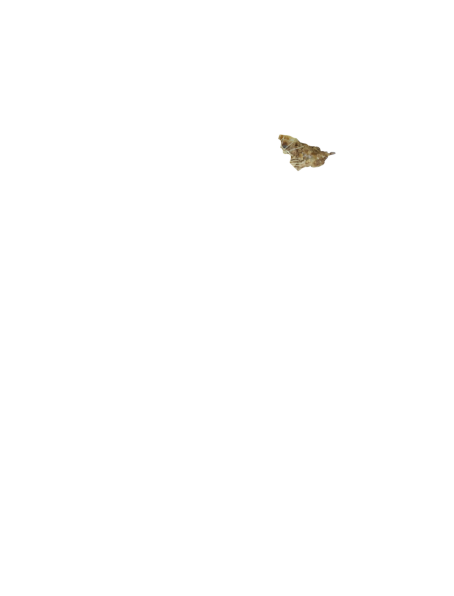

In [126]:
# I've prepared a mask for this 
damage_path = "../data/masks/IMG_8302/damage_1.png"
damage_mask = imread(damage_path)
just_damage = image_with_damage.copy()
just_damage[damage_mask != 0] = 255
plot_single(just_damage)

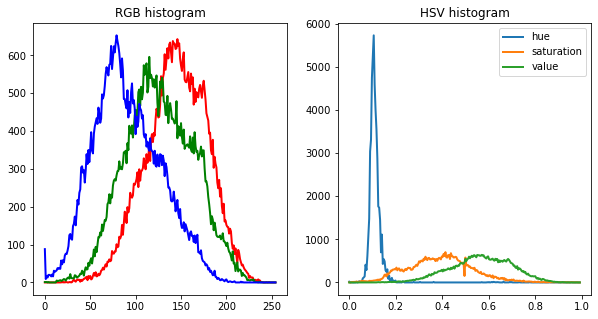

In [129]:
plot_histograms(image_with_damage, damage_mask)